In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=1)

In [4]:
import glob
import numpy as np
from PIL import Image
from utils.data import sample_indices


def load_shapes_dataset(dirpath='data/shapes'):
    x = []
    y = []

    label_dict = {
        'circles'   : 0,
        'squares'   : 1,
        'triangles' : 2
    }

    files = glob.glob(dirpath + '/**/*.png', recursive=True)

    for f in files:
        img=Image.open(f)
        img=img.resize(size=(28,28))
        img=img.convert('L')
        x.append(np.array(img))
        label = f.split('/')[-2]
        #y.append(label_dict[label])
        y.append(label)
        del img

    return np.array(x), np.array(y)

torch.Size([2000, 1, 28, 28]) torch.Size([50, 1, 28, 28])
tensor(0.) tensor(1.)


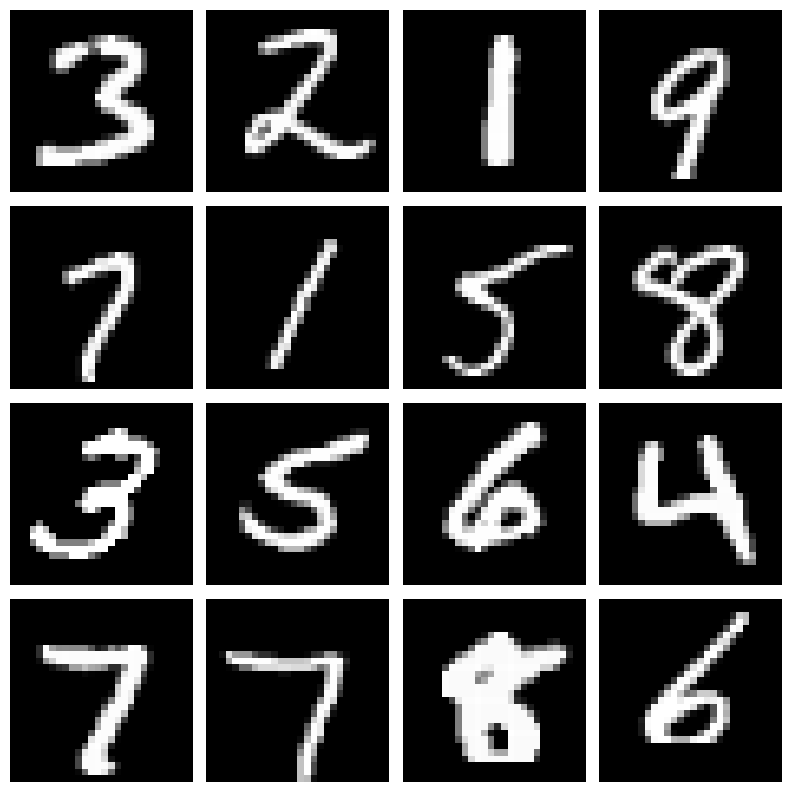

In [5]:
if DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    train_indeces = sample_indices(targets, k=90, seed=42)
    remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))


elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    train_indeces = sample_indices(mnist_trainset.targets, k=200, seed=42)
    remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=5, seed=42)

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)

In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    reconstruction_loss="bce",
    # n_lf=3,
    # eps_lf=1e-3,
    # beta_zero=0.3,
    # temperature=0.3,
    # regularization=1e-3
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['resnet']['encoder'](model_config),
    decoder=architecture_dict['resnet']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['resnet']['encoder'](model_config),
#     decoder=architecture_dict['resnet']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 143 µs, sys: 50 µs, total: 193 µs
Wall time: 197 µs


995848

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_ResNet_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=2048, bias=True)
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): ReLU()
      )
  

## Train

In [11]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=500,
    learning_rate=0.001,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-05-28_18-51-10. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 2000
 - per_device_eval_batch_size: 50
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fae01fcffd0>

Successfully launched training !



Training of epoch 1/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 17065832.0
Eval loss: 452.0533
--------------------------------------------------------------------------


Training of epoch 2/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 489.6473
Eval loss: 432.9617
--------------------------------------------------------------------------


Training of epoch 3/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 463.846
Eval loss: 408.1169
--------------------------------------------------------------------------


Training of epoch 4/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 425.9153
Eval loss: 378.6234
--------------------------------------------------------------------------


Training of epoch 5/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 385.1428
Eval loss: 358.5912
--------------------------------------------------------------------------


Training of epoch 6/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 360.8157
Eval loss: 357.0977
--------------------------------------------------------------------------


Training of epoch 7/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 361.6315
Eval loss: 325.4134
--------------------------------------------------------------------------


Training of epoch 8/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 331.6819
Eval loss: 302.8252
--------------------------------------------------------------------------


Training of epoch 9/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 305.2212
Eval loss: 290.7791
--------------------------------------------------------------------------


Training of epoch 10/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 293.5203
Eval loss: 277.4633
--------------------------------------------------------------------------


Training of epoch 11/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 279.7753
Eval loss: 263.5773
--------------------------------------------------------------------------


Training of epoch 12/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 264.7656
Eval loss: 261.7646
--------------------------------------------------------------------------


Training of epoch 13/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 260.5039
Eval loss: 256.9119
--------------------------------------------------------------------------


Training of epoch 14/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 255.5145
Eval loss: 247.3496
--------------------------------------------------------------------------


Training of epoch 15/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 244.9522
Eval loss: 240.4008
--------------------------------------------------------------------------


Training of epoch 16/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 238.0341
Eval loss: 239.1685
--------------------------------------------------------------------------


Training of epoch 17/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 237.8262
Eval loss: 235.3425
--------------------------------------------------------------------------


Training of epoch 18/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 232.6664
Eval loss: 230.5825
--------------------------------------------------------------------------


Training of epoch 19/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 227.5643
Eval loss: 232.9634
--------------------------------------------------------------------------


Training of epoch 20/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 228.4283
Eval loss: 229.375
--------------------------------------------------------------------------


Training of epoch 21/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 226.6805
Eval loss: 224.5887
--------------------------------------------------------------------------


Training of epoch 22/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 222.5406
Eval loss: 223.4519
--------------------------------------------------------------------------


Training of epoch 23/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 223.6364
Eval loss: 223.7031
--------------------------------------------------------------------------


Training of epoch 24/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 222.6321
Eval loss: 222.0974
--------------------------------------------------------------------------


Training of epoch 25/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 219.4739
Eval loss: 224.4767
--------------------------------------------------------------------------


Training of epoch 26/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 220.8394
Eval loss: 223.0998
--------------------------------------------------------------------------


Training of epoch 27/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 219.389
Eval loss: 218.7341
--------------------------------------------------------------------------


Training of epoch 28/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 216.473
Eval loss: 218.0995
--------------------------------------------------------------------------


Training of epoch 29/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 216.8697
Eval loss: 216.9909
--------------------------------------------------------------------------


Training of epoch 30/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 215.9785
Eval loss: 216.7076
--------------------------------------------------------------------------


Training of epoch 31/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 213.7538
Eval loss: 217.17
--------------------------------------------------------------------------


Training of epoch 32/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 214.1423
Eval loss: 216.102
--------------------------------------------------------------------------


Training of epoch 33/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 213.7818
Eval loss: 215.1465
--------------------------------------------------------------------------


Training of epoch 34/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 212.3866
Eval loss: 213.718
--------------------------------------------------------------------------


Training of epoch 35/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 212.0594
Eval loss: 214.6073
--------------------------------------------------------------------------


Training of epoch 36/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 212.179
Eval loss: 213.0739
--------------------------------------------------------------------------


Training of epoch 37/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 210.8247
Eval loss: 212.3762
--------------------------------------------------------------------------


Training of epoch 38/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 210.4567
Eval loss: 213.0688
--------------------------------------------------------------------------


Training of epoch 39/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 210.4012
Eval loss: 212.5593
--------------------------------------------------------------------------


Training of epoch 40/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 209.3317
Eval loss: 210.8265
--------------------------------------------------------------------------


Training of epoch 41/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 208.9873
Eval loss: 210.1534
--------------------------------------------------------------------------


Training of epoch 42/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 208.9073
Eval loss: 210.3401
--------------------------------------------------------------------------


Training of epoch 43/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 207.8516
Eval loss: 210.2059
--------------------------------------------------------------------------


Training of epoch 44/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 207.898
Eval loss: 209.6706
--------------------------------------------------------------------------


Training of epoch 45/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 207.0722
Eval loss: 208.2507
--------------------------------------------------------------------------


Training of epoch 46/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 206.3855
Eval loss: 208.2082
--------------------------------------------------------------------------


Training of epoch 47/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 206.4393
Eval loss: 207.0737
--------------------------------------------------------------------------


Training of epoch 48/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 205.3081
Eval loss: 207.4949
--------------------------------------------------------------------------


Training of epoch 49/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 205.1327
Eval loss: 206.9795
--------------------------------------------------------------------------


Training of epoch 50/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 204.5457
Eval loss: 205.6756
--------------------------------------------------------------------------


Training of epoch 51/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 203.9028
Eval loss: 206.278
--------------------------------------------------------------------------


Training of epoch 52/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 203.8507
Eval loss: 204.7165
--------------------------------------------------------------------------


Training of epoch 53/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 202.9471
Eval loss: 205.2187
--------------------------------------------------------------------------


Training of epoch 54/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 202.928
Eval loss: 204.3812
--------------------------------------------------------------------------


Training of epoch 55/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 202.0659
Eval loss: 203.9129
--------------------------------------------------------------------------


Training of epoch 56/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 201.7595
Eval loss: 203.5039
--------------------------------------------------------------------------


Training of epoch 57/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 201.1477
Eval loss: 203.0606
--------------------------------------------------------------------------


Training of epoch 58/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 200.6593
Eval loss: 202.6424
--------------------------------------------------------------------------


Training of epoch 59/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 200.3438
Eval loss: 202.1627
--------------------------------------------------------------------------


Training of epoch 60/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 199.8683
Eval loss: 201.9651
--------------------------------------------------------------------------


Training of epoch 61/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 199.6084
Eval loss: 201.5916
--------------------------------------------------------------------------


Training of epoch 62/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 199.2209
Eval loss: 201.3017
--------------------------------------------------------------------------


Training of epoch 63/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.8969
Eval loss: 200.4199
--------------------------------------------------------------------------


Training of epoch 64/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.3896
Eval loss: 199.7768
--------------------------------------------------------------------------


Training of epoch 65/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.0594
Eval loss: 199.1476
--------------------------------------------------------------------------


Training of epoch 66/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 197.778
Eval loss: 199.0416
--------------------------------------------------------------------------


Training of epoch 67/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 197.3553
Eval loss: 199.5413
--------------------------------------------------------------------------


Training of epoch 68/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 197.2695
Eval loss: 198.5659
--------------------------------------------------------------------------


Training of epoch 69/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.6582
Eval loss: 198.5604
--------------------------------------------------------------------------


Training of epoch 70/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.2839
Eval loss: 197.7803
--------------------------------------------------------------------------


Training of epoch 71/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 195.9131
Eval loss: 197.9604
--------------------------------------------------------------------------


Training of epoch 72/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 195.6361
Eval loss: 197.7769
--------------------------------------------------------------------------


Training of epoch 73/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 195.3709
Eval loss: 197.5905
--------------------------------------------------------------------------


Training of epoch 74/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 195.0046
Eval loss: 196.5722
--------------------------------------------------------------------------


Training of epoch 75/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 194.6965
Eval loss: 196.9503
--------------------------------------------------------------------------


Training of epoch 76/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 194.3144
Eval loss: 196.5684
--------------------------------------------------------------------------


Training of epoch 77/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.9961
Eval loss: 195.9785
--------------------------------------------------------------------------


Training of epoch 78/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.7934
Eval loss: 195.6685
--------------------------------------------------------------------------


Training of epoch 79/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.3722
Eval loss: 195.1453
--------------------------------------------------------------------------


Training of epoch 80/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.3004
Eval loss: 196.7809
--------------------------------------------------------------------------


Training of epoch 81/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.1903
Eval loss: 195.7988
--------------------------------------------------------------------------


Training of epoch 82/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 194.3452
Eval loss: 199.285
--------------------------------------------------------------------------


Training of epoch 83/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 197.0671
Eval loss: 202.5114
--------------------------------------------------------------------------


Training of epoch 84/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 201.0908
Eval loss: 194.7227
--------------------------------------------------------------------------


Training of epoch 85/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 192.2067
Eval loss: 199.6535
--------------------------------------------------------------------------


Training of epoch 86/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.7938
Eval loss: 196.6976
--------------------------------------------------------------------------


Training of epoch 87/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.8989
Eval loss: 198.443
--------------------------------------------------------------------------


Training of epoch 88/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.6396
Eval loss: 193.4702
--------------------------------------------------------------------------


Training of epoch 89/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 191.9553
Eval loss: 198.6033
--------------------------------------------------------------------------


Training of epoch 90/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.1316
Eval loss: 194.3601
--------------------------------------------------------------------------


Training of epoch 91/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 192.3545
Eval loss: 195.863
--------------------------------------------------------------------------


Training of epoch 92/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.0086
Eval loss: 195.883
--------------------------------------------------------------------------


Training of epoch 93/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.8683
Eval loss: 192.9199
--------------------------------------------------------------------------


Training of epoch 94/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 190.9618
Eval loss: 193.8948
--------------------------------------------------------------------------


Training of epoch 95/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 192.5811
Eval loss: 193.6082
--------------------------------------------------------------------------


Training of epoch 96/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 191.5272
Eval loss: 191.8016
--------------------------------------------------------------------------


Training of epoch 97/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 190.6092
Eval loss: 193.849
--------------------------------------------------------------------------


Training of epoch 98/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 191.6458
Eval loss: 191.3953
--------------------------------------------------------------------------


Training of epoch 99/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 189.991
Eval loss: 191.7466
--------------------------------------------------------------------------


Training of epoch 100/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 190.1854
Eval loss: 191.9586
--------------------------------------------------------------------------


Training of epoch 101/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 189.994
Eval loss: 190.0393
--------------------------------------------------------------------------


Training of epoch 102/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.9799
Eval loss: 190.9876
--------------------------------------------------------------------------


Training of epoch 103/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 189.6384
Eval loss: 189.9497
--------------------------------------------------------------------------


Training of epoch 104/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.1118
Eval loss: 191.6445
--------------------------------------------------------------------------


Training of epoch 105/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.9308
Eval loss: 190.0045
--------------------------------------------------------------------------


Training of epoch 106/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.814
Eval loss: 190.7898
--------------------------------------------------------------------------


Training of epoch 107/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.9931
Eval loss: 189.69
--------------------------------------------------------------------------


Training of epoch 108/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.4494
Eval loss: 188.8438
--------------------------------------------------------------------------


Training of epoch 109/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.1693
Eval loss: 189.5343
--------------------------------------------------------------------------


Training of epoch 110/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.0493
Eval loss: 189.9649
--------------------------------------------------------------------------


Training of epoch 111/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 186.6708
Eval loss: 187.6807
--------------------------------------------------------------------------


Training of epoch 112/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 186.4412
Eval loss: 188.3579
--------------------------------------------------------------------------


Training of epoch 113/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 186.2844
Eval loss: 188.7394
--------------------------------------------------------------------------


Training of epoch 114/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.8138
Eval loss: 188.3548
--------------------------------------------------------------------------


Training of epoch 115/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.9748
Eval loss: 188.3219
--------------------------------------------------------------------------


Training of epoch 116/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.3362
Eval loss: 187.3183
--------------------------------------------------------------------------


Training of epoch 117/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.4382
Eval loss: 187.0235
--------------------------------------------------------------------------


Training of epoch 118/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.98
Eval loss: 187.1402
--------------------------------------------------------------------------


Training of epoch 119/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.7075
Eval loss: 187.3843
--------------------------------------------------------------------------


Training of epoch 120/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.7224
Eval loss: 187.0682
--------------------------------------------------------------------------


Training of epoch 121/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.1989
Eval loss: 186.3351
--------------------------------------------------------------------------


Training of epoch 122/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.277
Eval loss: 186.5173
--------------------------------------------------------------------------


Training of epoch 123/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.1777
Eval loss: 186.1845
--------------------------------------------------------------------------


Training of epoch 124/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.7649
Eval loss: 185.7337
--------------------------------------------------------------------------


Training of epoch 125/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.3735
Eval loss: 185.9375
--------------------------------------------------------------------------


Training of epoch 126/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.6106
Eval loss: 185.8441
--------------------------------------------------------------------------


Training of epoch 127/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.6313
Eval loss: 186.1145
--------------------------------------------------------------------------


Training of epoch 128/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.0414
Eval loss: 185.0803
--------------------------------------------------------------------------


Training of epoch 129/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.7232
Eval loss: 184.8193
--------------------------------------------------------------------------


Training of epoch 130/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.514
Eval loss: 185.0108
--------------------------------------------------------------------------


Training of epoch 131/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.385
Eval loss: 185.0165
--------------------------------------------------------------------------


Training of epoch 132/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.7198
Eval loss: 185.6873
--------------------------------------------------------------------------


Training of epoch 133/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.1601
Eval loss: 186.2832
--------------------------------------------------------------------------


Training of epoch 134/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.3755
Eval loss: 186.2712
--------------------------------------------------------------------------


Training of epoch 135/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.7616
Eval loss: 185.4236
--------------------------------------------------------------------------


Training of epoch 136/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.6318
Eval loss: 184.9077
--------------------------------------------------------------------------


Training of epoch 137/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.4013
Eval loss: 184.9554
--------------------------------------------------------------------------


Training of epoch 138/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.732
Eval loss: 184.5018
--------------------------------------------------------------------------


Training of epoch 139/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.7607
Eval loss: 184.817
--------------------------------------------------------------------------


Training of epoch 140/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.2648
Eval loss: 184.7885
--------------------------------------------------------------------------


Training of epoch 141/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.9691
Eval loss: 184.5493
--------------------------------------------------------------------------


Training of epoch 142/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.0713
Eval loss: 184.5478
--------------------------------------------------------------------------


Training of epoch 143/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.0505
Eval loss: 182.7191
--------------------------------------------------------------------------


Training of epoch 144/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.186
Eval loss: 183.6392
--------------------------------------------------------------------------


Training of epoch 145/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.5233
Eval loss: 184.4164
--------------------------------------------------------------------------


Training of epoch 146/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.831
Eval loss: 183.2236
--------------------------------------------------------------------------


Training of epoch 147/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.1231
Eval loss: 183.2479
--------------------------------------------------------------------------


Training of epoch 148/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.935
Eval loss: 183.5033
--------------------------------------------------------------------------


Training of epoch 149/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.8866
Eval loss: 183.0524
--------------------------------------------------------------------------


Training of epoch 150/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.1163
Eval loss: 184.2055
--------------------------------------------------------------------------


Training of epoch 151/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.3109
Eval loss: 182.4127
--------------------------------------------------------------------------


Training of epoch 152/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.4153
Eval loss: 182.739
--------------------------------------------------------------------------


Training of epoch 153/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.0487
Eval loss: 182.2406
--------------------------------------------------------------------------


Training of epoch 154/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.442
Eval loss: 182.104
--------------------------------------------------------------------------


Training of epoch 155/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.2109
Eval loss: 183.9052
--------------------------------------------------------------------------


Training of epoch 156/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.4111
Eval loss: 182.7451
--------------------------------------------------------------------------


Training of epoch 157/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.703
Eval loss: 184.3649
--------------------------------------------------------------------------


Training of epoch 158/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.8214
Eval loss: 182.2443
--------------------------------------------------------------------------


Training of epoch 159/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.3125
Eval loss: 182.9833
--------------------------------------------------------------------------


Training of epoch 160/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.3629
Eval loss: 181.9153
--------------------------------------------------------------------------


Training of epoch 161/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.1296
Eval loss: 182.4868
--------------------------------------------------------------------------


Training of epoch 162/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.3985
Eval loss: 182.9167
--------------------------------------------------------------------------


Training of epoch 163/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.5941
Eval loss: 182.0613
--------------------------------------------------------------------------


Training of epoch 164/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.0253
Eval loss: 181.531
--------------------------------------------------------------------------


Training of epoch 165/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.146
Eval loss: 181.1469
--------------------------------------------------------------------------


Training of epoch 166/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.3837
Eval loss: 182.4659
--------------------------------------------------------------------------


Training of epoch 167/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.9628
Eval loss: 182.1548
--------------------------------------------------------------------------


Training of epoch 168/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.9422
Eval loss: 181.5918
--------------------------------------------------------------------------


Training of epoch 169/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.798
Eval loss: 182.3425
--------------------------------------------------------------------------


Training of epoch 170/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.6037
Eval loss: 180.4636
--------------------------------------------------------------------------


Training of epoch 171/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.7675
Eval loss: 181.1925
--------------------------------------------------------------------------


Training of epoch 172/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.9696
Eval loss: 180.7869
--------------------------------------------------------------------------


Training of epoch 173/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.5625
Eval loss: 181.5865
--------------------------------------------------------------------------


Training of epoch 174/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.8258
Eval loss: 181.563
--------------------------------------------------------------------------


Training of epoch 175/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.8152
Eval loss: 181.5621
--------------------------------------------------------------------------


Training of epoch 176/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.5548
Eval loss: 181.7013
--------------------------------------------------------------------------


Training of epoch 177/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.7547
Eval loss: 181.3224
--------------------------------------------------------------------------


Training of epoch 178/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.2832
Eval loss: 180.9399
--------------------------------------------------------------------------


Training of epoch 179/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.461
Eval loss: 180.5107
--------------------------------------------------------------------------


Training of epoch 180/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.1274
Eval loss: 180.6889
--------------------------------------------------------------------------


Training of epoch 181/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.768
Eval loss: 181.3236
--------------------------------------------------------------------------


Epoch 00181: reducing learning rate of group 0 to 5.0000e-04.


Training of epoch 182/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.7185
Eval loss: 179.9705
--------------------------------------------------------------------------


Training of epoch 183/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.358
Eval loss: 180.5648
--------------------------------------------------------------------------


Training of epoch 184/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.4506
Eval loss: 180.6506
--------------------------------------------------------------------------


Training of epoch 185/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.1856
Eval loss: 180.6766
--------------------------------------------------------------------------


Training of epoch 186/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.2352
Eval loss: 179.3506
--------------------------------------------------------------------------


Training of epoch 187/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.0694
Eval loss: 180.4976
--------------------------------------------------------------------------


Training of epoch 188/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.114
Eval loss: 179.937
--------------------------------------------------------------------------


Training of epoch 189/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.9529
Eval loss: 180.413
--------------------------------------------------------------------------


Training of epoch 190/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.9431
Eval loss: 180.3843
--------------------------------------------------------------------------


Training of epoch 191/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.7591
Eval loss: 180.252
--------------------------------------------------------------------------


Training of epoch 192/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.8232
Eval loss: 179.7113
--------------------------------------------------------------------------


Training of epoch 193/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.6217
Eval loss: 180.2249
--------------------------------------------------------------------------


Training of epoch 194/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.6403
Eval loss: 179.6958
--------------------------------------------------------------------------


Training of epoch 195/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.4886
Eval loss: 180.0672
--------------------------------------------------------------------------


Training of epoch 196/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.4981
Eval loss: 179.9415
--------------------------------------------------------------------------


Training of epoch 197/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.4605
Eval loss: 180.0589
--------------------------------------------------------------------------


Epoch 00197: reducing learning rate of group 0 to 2.5000e-04.


Training of epoch 198/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.3003
Eval loss: 180.2875
--------------------------------------------------------------------------


Training of epoch 199/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.2329
Eval loss: 179.6835
--------------------------------------------------------------------------


Training of epoch 200/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.2093
Eval loss: 180.3034
--------------------------------------------------------------------------


Training of epoch 201/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 201/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.0705
Eval loss: 179.3087
--------------------------------------------------------------------------


Training of epoch 202/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 202/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.1717
Eval loss: 179.3926
--------------------------------------------------------------------------


Training of epoch 203/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 203/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.0893
Eval loss: 179.5945
--------------------------------------------------------------------------


Training of epoch 204/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 204/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.0368
Eval loss: 179.6782
--------------------------------------------------------------------------


Training of epoch 205/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 205/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.9742
Eval loss: 179.7863
--------------------------------------------------------------------------


Training of epoch 206/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 206/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.0041
Eval loss: 179.9336
--------------------------------------------------------------------------


Training of epoch 207/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 207/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.9558
Eval loss: 179.6407
--------------------------------------------------------------------------


Training of epoch 208/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 208/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.9464
Eval loss: 179.938
--------------------------------------------------------------------------


Training of epoch 209/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 209/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.8067
Eval loss: 179.3194
--------------------------------------------------------------------------


Training of epoch 210/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 210/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.8302
Eval loss: 179.363
--------------------------------------------------------------------------


Training of epoch 211/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 211/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.7746
Eval loss: 179.4632
--------------------------------------------------------------------------


Training of epoch 212/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 212/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.753
Eval loss: 179.2157
--------------------------------------------------------------------------


Training of epoch 213/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 213/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.7149
Eval loss: 178.9411
--------------------------------------------------------------------------


Training of epoch 214/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 214/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.7179
Eval loss: 179.1187
--------------------------------------------------------------------------


Training of epoch 215/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 215/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.652
Eval loss: 179.3293
--------------------------------------------------------------------------


Training of epoch 216/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 216/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.5529
Eval loss: 179.8962
--------------------------------------------------------------------------


Training of epoch 217/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 217/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.6152
Eval loss: 180.2377
--------------------------------------------------------------------------


Training of epoch 218/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 218/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.4946
Eval loss: 178.6216
--------------------------------------------------------------------------


Training of epoch 219/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 219/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.4391
Eval loss: 178.8186
--------------------------------------------------------------------------


Training of epoch 220/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 220/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.4068
Eval loss: 179.2051
--------------------------------------------------------------------------


Training of epoch 221/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 221/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.3828
Eval loss: 179.1938
--------------------------------------------------------------------------


Training of epoch 222/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 222/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.3325
Eval loss: 179.3175
--------------------------------------------------------------------------


Training of epoch 223/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 223/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.2831
Eval loss: 179.1631
--------------------------------------------------------------------------


Training of epoch 224/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 224/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.2219
Eval loss: 178.9469
--------------------------------------------------------------------------


Training of epoch 225/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 225/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.189
Eval loss: 179.5368
--------------------------------------------------------------------------


Training of epoch 226/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 226/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.2437
Eval loss: 179.2258
--------------------------------------------------------------------------


Training of epoch 227/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 227/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.149
Eval loss: 179.3196
--------------------------------------------------------------------------


Training of epoch 228/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 228/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.0763
Eval loss: 179.3813
--------------------------------------------------------------------------


Training of epoch 229/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 229/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.0395
Eval loss: 179.0589
--------------------------------------------------------------------------


Epoch 00229: reducing learning rate of group 0 to 1.2500e-04.


Training of epoch 230/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 230/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.0289
Eval loss: 178.8309
--------------------------------------------------------------------------


Training of epoch 231/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 231/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.9745
Eval loss: 179.0417
--------------------------------------------------------------------------


Training of epoch 232/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 232/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.9531
Eval loss: 179.1024
--------------------------------------------------------------------------


Training of epoch 233/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 233/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.977
Eval loss: 178.4875
--------------------------------------------------------------------------


Training of epoch 234/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 234/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.952
Eval loss: 179.4323
--------------------------------------------------------------------------


Training of epoch 235/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 235/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.8009
Eval loss: 179.1086
--------------------------------------------------------------------------


Training of epoch 236/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 236/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.9228
Eval loss: 178.8466
--------------------------------------------------------------------------


Training of epoch 237/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 237/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.9124
Eval loss: 179.4909
--------------------------------------------------------------------------


Training of epoch 238/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 238/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.828
Eval loss: 178.4779
--------------------------------------------------------------------------


Training of epoch 239/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 239/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.8377
Eval loss: 178.8297
--------------------------------------------------------------------------


Training of epoch 240/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 240/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7316
Eval loss: 178.953
--------------------------------------------------------------------------


Training of epoch 241/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 241/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.8499
Eval loss: 178.933
--------------------------------------------------------------------------


Training of epoch 242/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 242/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7953
Eval loss: 178.9981
--------------------------------------------------------------------------


Training of epoch 243/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 243/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7179
Eval loss: 179.0648
--------------------------------------------------------------------------


Training of epoch 244/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 244/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7932
Eval loss: 178.8127
--------------------------------------------------------------------------


Epoch 00244: reducing learning rate of group 0 to 6.2500e-05.


Training of epoch 245/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 245/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7384
Eval loss: 178.2209
--------------------------------------------------------------------------


Training of epoch 246/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 246/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.6295
Eval loss: 178.7519
--------------------------------------------------------------------------


Training of epoch 247/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 247/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.6912
Eval loss: 178.6609
--------------------------------------------------------------------------


Training of epoch 248/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 248/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.7455
Eval loss: 178.6109
--------------------------------------------------------------------------


Training of epoch 249/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 249/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5849
Eval loss: 178.6877
--------------------------------------------------------------------------


Training of epoch 250/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 250/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.6729
Eval loss: 178.6991
--------------------------------------------------------------------------


Training of epoch 251/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 251/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.6
Eval loss: 178.6721
--------------------------------------------------------------------------


Training of epoch 252/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 252/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5935
Eval loss: 179.5024
--------------------------------------------------------------------------


Training of epoch 253/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 253/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5675
Eval loss: 179.2718
--------------------------------------------------------------------------


Training of epoch 254/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 254/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5712
Eval loss: 178.3646
--------------------------------------------------------------------------


Training of epoch 255/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 255/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.613
Eval loss: 179.0044
--------------------------------------------------------------------------


Training of epoch 256/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 256/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5446
Eval loss: 178.6258
--------------------------------------------------------------------------


Epoch 00256: reducing learning rate of group 0 to 3.1250e-05.


Training of epoch 257/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 257/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5272
Eval loss: 179.0672
--------------------------------------------------------------------------


Training of epoch 258/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 258/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5716
Eval loss: 179.3325
--------------------------------------------------------------------------


Training of epoch 259/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 259/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.589
Eval loss: 178.8987
--------------------------------------------------------------------------


Training of epoch 260/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 260/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5576
Eval loss: 178.9732
--------------------------------------------------------------------------


Training of epoch 261/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 261/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5486
Eval loss: 178.3954
--------------------------------------------------------------------------


Training of epoch 262/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 262/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5193
Eval loss: 178.5717
--------------------------------------------------------------------------


Training of epoch 263/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 263/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.481
Eval loss: 178.892
--------------------------------------------------------------------------


Training of epoch 264/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 264/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4677
Eval loss: 178.7763
--------------------------------------------------------------------------


Training of epoch 265/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 265/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5171
Eval loss: 179.0038
--------------------------------------------------------------------------


Training of epoch 266/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 266/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4305
Eval loss: 179.0507
--------------------------------------------------------------------------


Training of epoch 267/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 267/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4136
Eval loss: 179.038
--------------------------------------------------------------------------


Epoch 00267: reducing learning rate of group 0 to 1.5625e-05.


Training of epoch 268/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 268/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5022
Eval loss: 178.8279
--------------------------------------------------------------------------


Training of epoch 269/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 269/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4736
Eval loss: 179.1018
--------------------------------------------------------------------------


Training of epoch 270/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 270/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4516
Eval loss: 178.831
--------------------------------------------------------------------------


Training of epoch 271/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 271/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.386
Eval loss: 179.4455
--------------------------------------------------------------------------


Training of epoch 272/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 272/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4555
Eval loss: 178.8831
--------------------------------------------------------------------------


Training of epoch 273/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 273/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4497
Eval loss: 178.8562
--------------------------------------------------------------------------


Training of epoch 274/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 274/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4554
Eval loss: 179.4805
--------------------------------------------------------------------------


Training of epoch 275/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 275/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4589
Eval loss: 179.5327
--------------------------------------------------------------------------


Training of epoch 276/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 276/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4382
Eval loss: 179.4152
--------------------------------------------------------------------------


Training of epoch 277/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 277/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.461
Eval loss: 178.7716
--------------------------------------------------------------------------


Training of epoch 278/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 278/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4914
Eval loss: 178.8002
--------------------------------------------------------------------------


Epoch 00278: reducing learning rate of group 0 to 7.8125e-06.


Training of epoch 279/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 279/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4441
Eval loss: 178.998
--------------------------------------------------------------------------


Training of epoch 280/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 280/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4555
Eval loss: 179.2487
--------------------------------------------------------------------------


Training of epoch 281/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 281/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3967
Eval loss: 178.864
--------------------------------------------------------------------------


Training of epoch 282/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 282/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4308
Eval loss: 178.5077
--------------------------------------------------------------------------


Training of epoch 283/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 283/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4684
Eval loss: 178.5598
--------------------------------------------------------------------------


Training of epoch 284/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 284/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4621
Eval loss: 178.8988
--------------------------------------------------------------------------


Training of epoch 285/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 285/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.48
Eval loss: 179.0149
--------------------------------------------------------------------------


Training of epoch 286/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 286/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3788
Eval loss: 178.2938
--------------------------------------------------------------------------


Training of epoch 287/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 287/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4924
Eval loss: 178.7998
--------------------------------------------------------------------------


Training of epoch 288/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 288/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4447
Eval loss: 179.0902
--------------------------------------------------------------------------


Training of epoch 289/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 289/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4211
Eval loss: 178.6657
--------------------------------------------------------------------------


Epoch 00289: reducing learning rate of group 0 to 3.9063e-06.


Training of epoch 290/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 290/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3914
Eval loss: 178.1714
--------------------------------------------------------------------------


Training of epoch 291/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 291/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4769
Eval loss: 178.3465
--------------------------------------------------------------------------


Training of epoch 292/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 292/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4393
Eval loss: 178.7692
--------------------------------------------------------------------------


Training of epoch 293/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 293/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4557
Eval loss: 179.5332
--------------------------------------------------------------------------


Training of epoch 294/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 294/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4246
Eval loss: 179.1285
--------------------------------------------------------------------------


Training of epoch 295/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 295/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3592
Eval loss: 179.2236
--------------------------------------------------------------------------


Training of epoch 296/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 296/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4329
Eval loss: 178.7039
--------------------------------------------------------------------------


Training of epoch 297/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 297/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4734
Eval loss: 178.52
--------------------------------------------------------------------------


Training of epoch 298/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 298/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4319
Eval loss: 179.0288
--------------------------------------------------------------------------


Training of epoch 299/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 299/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3926
Eval loss: 178.8957
--------------------------------------------------------------------------


Training of epoch 300/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 300/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4286
Eval loss: 179.2731
--------------------------------------------------------------------------


Training of epoch 301/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 301/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3842
Eval loss: 178.4932
--------------------------------------------------------------------------


Epoch 00301: reducing learning rate of group 0 to 1.9531e-06.


Training of epoch 302/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 302/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.447
Eval loss: 178.9996
--------------------------------------------------------------------------


Training of epoch 303/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 303/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4721
Eval loss: 179.088
--------------------------------------------------------------------------


Training of epoch 304/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 304/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3905
Eval loss: 178.4518
--------------------------------------------------------------------------


Training of epoch 305/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 305/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3565
Eval loss: 178.3394
--------------------------------------------------------------------------


Training of epoch 306/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 306/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4466
Eval loss: 178.1444
--------------------------------------------------------------------------


Training of epoch 307/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 307/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4131
Eval loss: 178.3946
--------------------------------------------------------------------------


Training of epoch 308/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 308/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4322
Eval loss: 178.9262
--------------------------------------------------------------------------


Training of epoch 309/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 309/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4582
Eval loss: 178.4633
--------------------------------------------------------------------------


Training of epoch 310/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 310/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3336
Eval loss: 178.9934
--------------------------------------------------------------------------


Training of epoch 311/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 311/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4248
Eval loss: 178.8523
--------------------------------------------------------------------------


Training of epoch 312/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 312/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3965
Eval loss: 178.7317
--------------------------------------------------------------------------


Training of epoch 313/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 313/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3468
Eval loss: 178.5632
--------------------------------------------------------------------------


Training of epoch 314/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 314/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4512
Eval loss: 178.8091
--------------------------------------------------------------------------


Training of epoch 315/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 315/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3602
Eval loss: 178.5725
--------------------------------------------------------------------------


Training of epoch 316/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 316/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4561
Eval loss: 179.7159
--------------------------------------------------------------------------


Training of epoch 317/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 317/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3287
Eval loss: 178.5073
--------------------------------------------------------------------------


Epoch 00317: reducing learning rate of group 0 to 9.7656e-07.


Training of epoch 318/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 318/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4249
Eval loss: 179.0762
--------------------------------------------------------------------------


Training of epoch 319/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 319/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.401
Eval loss: 178.7608
--------------------------------------------------------------------------


Training of epoch 320/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 320/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3778
Eval loss: 178.8621
--------------------------------------------------------------------------


Training of epoch 321/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 321/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5222
Eval loss: 178.772
--------------------------------------------------------------------------


Training of epoch 322/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 322/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3787
Eval loss: 179.5788
--------------------------------------------------------------------------


Training of epoch 323/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 323/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3
Eval loss: 178.3407
--------------------------------------------------------------------------


Training of epoch 324/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 324/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3878
Eval loss: 178.5492
--------------------------------------------------------------------------


Training of epoch 325/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 325/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4059
Eval loss: 178.9851
--------------------------------------------------------------------------


Training of epoch 326/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 326/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3367
Eval loss: 179.0274
--------------------------------------------------------------------------


Training of epoch 327/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 327/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4335
Eval loss: 179.1496
--------------------------------------------------------------------------


Training of epoch 328/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 328/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4063
Eval loss: 178.6129
--------------------------------------------------------------------------


Epoch 00328: reducing learning rate of group 0 to 4.8828e-07.


Training of epoch 329/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 329/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4534
Eval loss: 178.938
--------------------------------------------------------------------------


Training of epoch 330/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 330/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3282
Eval loss: 178.92
--------------------------------------------------------------------------


Training of epoch 331/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 331/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3381
Eval loss: 178.8463
--------------------------------------------------------------------------


Training of epoch 332/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 332/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3273
Eval loss: 178.3659
--------------------------------------------------------------------------


Training of epoch 333/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 333/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3836
Eval loss: 178.9302
--------------------------------------------------------------------------


Training of epoch 334/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 334/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3569
Eval loss: 178.4918
--------------------------------------------------------------------------


Training of epoch 335/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 335/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3729
Eval loss: 178.8217
--------------------------------------------------------------------------


Training of epoch 336/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 336/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3417
Eval loss: 178.9631
--------------------------------------------------------------------------


Training of epoch 337/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 337/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5176
Eval loss: 179.0557
--------------------------------------------------------------------------


Training of epoch 338/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 338/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4299
Eval loss: 178.5838
--------------------------------------------------------------------------


Training of epoch 339/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 339/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4472
Eval loss: 178.6579
--------------------------------------------------------------------------


Epoch 00339: reducing learning rate of group 0 to 2.4414e-07.


Training of epoch 340/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 340/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3845
Eval loss: 178.8783
--------------------------------------------------------------------------


Training of epoch 341/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 341/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4914
Eval loss: 178.6645
--------------------------------------------------------------------------


Training of epoch 342/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 342/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4552
Eval loss: 178.7764
--------------------------------------------------------------------------


Training of epoch 343/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 343/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4544
Eval loss: 179.1969
--------------------------------------------------------------------------


Training of epoch 344/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 344/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3475
Eval loss: 178.77
--------------------------------------------------------------------------


Training of epoch 345/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 345/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3903
Eval loss: 178.682
--------------------------------------------------------------------------


Training of epoch 346/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 346/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4593
Eval loss: 178.6368
--------------------------------------------------------------------------


Training of epoch 347/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 347/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4625
Eval loss: 178.6856
--------------------------------------------------------------------------


Training of epoch 348/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 348/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3468
Eval loss: 178.2565
--------------------------------------------------------------------------


Training of epoch 349/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 349/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4604
Eval loss: 178.7005
--------------------------------------------------------------------------


Training of epoch 350/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 350/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3911
Eval loss: 179.2168
--------------------------------------------------------------------------


Epoch 00350: reducing learning rate of group 0 to 1.2207e-07.


Training of epoch 351/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 351/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4344
Eval loss: 178.7458
--------------------------------------------------------------------------


Training of epoch 352/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 352/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4182
Eval loss: 179.0346
--------------------------------------------------------------------------


Training of epoch 353/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 353/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3606
Eval loss: 178.4791
--------------------------------------------------------------------------


Training of epoch 354/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 354/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3687
Eval loss: 179.0292
--------------------------------------------------------------------------


Training of epoch 355/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 355/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3964
Eval loss: 179.1266
--------------------------------------------------------------------------


Training of epoch 356/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 356/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3945
Eval loss: 178.765
--------------------------------------------------------------------------


Training of epoch 357/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 357/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3824
Eval loss: 178.1604
--------------------------------------------------------------------------


Training of epoch 358/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 358/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3537
Eval loss: 178.451
--------------------------------------------------------------------------


Training of epoch 359/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 359/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3943
Eval loss: 178.8112
--------------------------------------------------------------------------


Training of epoch 360/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 360/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3843
Eval loss: 179.0368
--------------------------------------------------------------------------


Training of epoch 361/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 361/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3148
Eval loss: 179.1093
--------------------------------------------------------------------------


Epoch 00361: reducing learning rate of group 0 to 6.1035e-08.


Training of epoch 362/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 362/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.332
Eval loss: 179.1812
--------------------------------------------------------------------------


Training of epoch 363/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 363/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.445
Eval loss: 178.5433
--------------------------------------------------------------------------


Training of epoch 364/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 364/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4373
Eval loss: 179.3002
--------------------------------------------------------------------------


Training of epoch 365/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 365/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4049
Eval loss: 178.5439
--------------------------------------------------------------------------


Training of epoch 366/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 366/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4691
Eval loss: 178.8375
--------------------------------------------------------------------------


Training of epoch 367/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 367/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3343
Eval loss: 178.4769
--------------------------------------------------------------------------


Training of epoch 368/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 368/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3769
Eval loss: 179.055
--------------------------------------------------------------------------


Training of epoch 369/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 369/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4323
Eval loss: 178.8129
--------------------------------------------------------------------------


Training of epoch 370/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 370/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3678
Eval loss: 178.3368
--------------------------------------------------------------------------


Training of epoch 371/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 371/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4371
Eval loss: 178.1909
--------------------------------------------------------------------------


Training of epoch 372/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 372/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3331
Eval loss: 178.9483
--------------------------------------------------------------------------


Epoch 00372: reducing learning rate of group 0 to 3.0518e-08.


Training of epoch 373/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 373/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4338
Eval loss: 178.5517
--------------------------------------------------------------------------


Training of epoch 374/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 374/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4355
Eval loss: 178.5652
--------------------------------------------------------------------------


Training of epoch 375/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 375/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3514
Eval loss: 178.1089
--------------------------------------------------------------------------


Training of epoch 376/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 376/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4548
Eval loss: 178.3485
--------------------------------------------------------------------------


Training of epoch 377/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 377/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3789
Eval loss: 179.1141
--------------------------------------------------------------------------


Training of epoch 378/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 378/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4
Eval loss: 178.7791
--------------------------------------------------------------------------


Training of epoch 379/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 379/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3705
Eval loss: 178.4296
--------------------------------------------------------------------------


Training of epoch 380/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 380/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3636
Eval loss: 178.5231
--------------------------------------------------------------------------


Training of epoch 381/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 381/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3947
Eval loss: 179.1368
--------------------------------------------------------------------------


Training of epoch 382/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 382/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4061
Eval loss: 178.7017
--------------------------------------------------------------------------


Training of epoch 383/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 383/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3676
Eval loss: 178.8142
--------------------------------------------------------------------------


Training of epoch 384/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 384/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3913
Eval loss: 178.8201
--------------------------------------------------------------------------


Training of epoch 385/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 385/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4219
Eval loss: 178.9101
--------------------------------------------------------------------------


Training of epoch 386/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 386/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4424
Eval loss: 178.5889
--------------------------------------------------------------------------


Epoch 00386: reducing learning rate of group 0 to 1.5259e-08.


Training of epoch 387/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 387/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3219
Eval loss: 178.5879
--------------------------------------------------------------------------


Training of epoch 388/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 388/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3721
Eval loss: 178.9428
--------------------------------------------------------------------------


Training of epoch 389/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 389/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4186
Eval loss: 178.7222
--------------------------------------------------------------------------


Training of epoch 390/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 390/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3916
Eval loss: 178.9173
--------------------------------------------------------------------------


Training of epoch 391/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 391/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4481
Eval loss: 178.9584
--------------------------------------------------------------------------


Training of epoch 392/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 392/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4109
Eval loss: 178.6508
--------------------------------------------------------------------------


Training of epoch 393/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 393/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3276
Eval loss: 178.6574
--------------------------------------------------------------------------


Training of epoch 394/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 394/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3821
Eval loss: 178.514
--------------------------------------------------------------------------


Training of epoch 395/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 395/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3719
Eval loss: 178.8184
--------------------------------------------------------------------------


Training of epoch 396/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 396/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3139
Eval loss: 178.5932
--------------------------------------------------------------------------


Training of epoch 397/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 397/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4114
Eval loss: 178.2654
--------------------------------------------------------------------------


Training of epoch 398/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 398/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4377
Eval loss: 178.0454
--------------------------------------------------------------------------


Training of epoch 399/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 399/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4162
Eval loss: 178.522
--------------------------------------------------------------------------


Training of epoch 400/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 400/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3469
Eval loss: 178.9137
--------------------------------------------------------------------------


Training of epoch 401/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 401/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4001
Eval loss: 178.9618
--------------------------------------------------------------------------


Training of epoch 402/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 402/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4184
Eval loss: 179.0495
--------------------------------------------------------------------------


Training of epoch 403/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 403/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4527
Eval loss: 179.0233
--------------------------------------------------------------------------


Training of epoch 404/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 404/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.438
Eval loss: 178.6374
--------------------------------------------------------------------------


Training of epoch 405/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 405/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4748
Eval loss: 178.3341
--------------------------------------------------------------------------


Training of epoch 406/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 406/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4224
Eval loss: 178.9784
--------------------------------------------------------------------------


Training of epoch 407/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 407/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4299
Eval loss: 178.9672
--------------------------------------------------------------------------


Training of epoch 408/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 408/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3704
Eval loss: 179.1171
--------------------------------------------------------------------------


Training of epoch 409/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 409/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4095
Eval loss: 178.8323
--------------------------------------------------------------------------


Training of epoch 410/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 410/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4244
Eval loss: 178.8509
--------------------------------------------------------------------------


Training of epoch 411/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 411/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3784
Eval loss: 178.3663
--------------------------------------------------------------------------


Training of epoch 412/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 412/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4449
Eval loss: 179.1787
--------------------------------------------------------------------------


Training of epoch 413/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 413/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3907
Eval loss: 178.6127
--------------------------------------------------------------------------


Training of epoch 414/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 414/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3831
Eval loss: 179.1468
--------------------------------------------------------------------------


Training of epoch 415/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 415/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4034
Eval loss: 179.2357
--------------------------------------------------------------------------


Training of epoch 416/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 416/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3318
Eval loss: 179.2138
--------------------------------------------------------------------------


Training of epoch 417/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 417/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4086
Eval loss: 178.8302
--------------------------------------------------------------------------


Training of epoch 418/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 418/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3934
Eval loss: 178.9584
--------------------------------------------------------------------------


Training of epoch 419/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 419/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4507
Eval loss: 178.6148
--------------------------------------------------------------------------


Training of epoch 420/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 420/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3752
Eval loss: 179.1548
--------------------------------------------------------------------------


Training of epoch 421/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 421/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3842
Eval loss: 179.0056
--------------------------------------------------------------------------


Training of epoch 422/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 422/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.365
Eval loss: 178.8303
--------------------------------------------------------------------------


Training of epoch 423/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 423/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3677
Eval loss: 178.1783
--------------------------------------------------------------------------


Training of epoch 424/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 424/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.363
Eval loss: 178.8002
--------------------------------------------------------------------------


Training of epoch 425/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 425/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4283
Eval loss: 178.553
--------------------------------------------------------------------------


Training of epoch 426/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 426/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3979
Eval loss: 179.0389
--------------------------------------------------------------------------


Training of epoch 427/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 427/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.399
Eval loss: 178.416
--------------------------------------------------------------------------


Training of epoch 428/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 428/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4397
Eval loss: 179.1167
--------------------------------------------------------------------------


Training of epoch 429/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 429/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4317
Eval loss: 178.4741
--------------------------------------------------------------------------


Training of epoch 430/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 430/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4046
Eval loss: 179.049
--------------------------------------------------------------------------


Training of epoch 431/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 431/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4444
Eval loss: 178.4522
--------------------------------------------------------------------------


Training of epoch 432/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 432/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3857
Eval loss: 178.4761
--------------------------------------------------------------------------


Training of epoch 433/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 433/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4186
Eval loss: 178.2401
--------------------------------------------------------------------------


Training of epoch 434/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 434/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3537
Eval loss: 179.0113
--------------------------------------------------------------------------


Training of epoch 435/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 435/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4295
Eval loss: 178.8597
--------------------------------------------------------------------------


Training of epoch 436/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 436/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3629
Eval loss: 178.9686
--------------------------------------------------------------------------


Training of epoch 437/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 437/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3833
Eval loss: 178.8037
--------------------------------------------------------------------------


Training of epoch 438/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 438/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3559
Eval loss: 178.5962
--------------------------------------------------------------------------


Training of epoch 439/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 439/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4074
Eval loss: 178.5069
--------------------------------------------------------------------------


Training of epoch 440/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 440/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4205
Eval loss: 178.5965
--------------------------------------------------------------------------


Training of epoch 441/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 441/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4579
Eval loss: 178.387
--------------------------------------------------------------------------


Training of epoch 442/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 442/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3672
Eval loss: 178.6863
--------------------------------------------------------------------------


Training of epoch 443/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 443/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.381
Eval loss: 178.38
--------------------------------------------------------------------------


Training of epoch 444/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 444/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3745
Eval loss: 178.9401
--------------------------------------------------------------------------


Training of epoch 445/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 445/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4624
Eval loss: 178.6372
--------------------------------------------------------------------------


Training of epoch 446/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 446/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.47
Eval loss: 178.8464
--------------------------------------------------------------------------


Training of epoch 447/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 447/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3973
Eval loss: 178.6526
--------------------------------------------------------------------------


Training of epoch 448/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 448/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3925
Eval loss: 178.8203
--------------------------------------------------------------------------


Training of epoch 449/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 449/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4499
Eval loss: 178.6265
--------------------------------------------------------------------------


Training of epoch 450/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 450/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3861
Eval loss: 179.1867
--------------------------------------------------------------------------


Training of epoch 451/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 451/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.407
Eval loss: 179.046
--------------------------------------------------------------------------


Training of epoch 452/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 452/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4061
Eval loss: 178.8796
--------------------------------------------------------------------------


Training of epoch 453/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 453/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4117
Eval loss: 178.5689
--------------------------------------------------------------------------


Training of epoch 454/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 454/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3742
Eval loss: 178.4152
--------------------------------------------------------------------------


Training of epoch 455/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 455/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3817
Eval loss: 178.6194
--------------------------------------------------------------------------


Training of epoch 456/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 456/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4299
Eval loss: 179.0553
--------------------------------------------------------------------------


Training of epoch 457/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 457/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.419
Eval loss: 178.8021
--------------------------------------------------------------------------


Training of epoch 458/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 458/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4164
Eval loss: 178.0868
--------------------------------------------------------------------------


Training of epoch 459/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 459/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4518
Eval loss: 178.824
--------------------------------------------------------------------------


Training of epoch 460/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 460/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3987
Eval loss: 179.6746
--------------------------------------------------------------------------


Training of epoch 461/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 461/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.426
Eval loss: 178.3958
--------------------------------------------------------------------------


Training of epoch 462/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 462/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4134
Eval loss: 178.5753
--------------------------------------------------------------------------


Training of epoch 463/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 463/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4365
Eval loss: 178.0742
--------------------------------------------------------------------------


Training of epoch 464/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 464/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4591
Eval loss: 179.3239
--------------------------------------------------------------------------


Training of epoch 465/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 465/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3682
Eval loss: 179.0064
--------------------------------------------------------------------------


Training of epoch 466/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 466/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3743
Eval loss: 178.2384
--------------------------------------------------------------------------


Training of epoch 467/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 467/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4142
Eval loss: 179.0238
--------------------------------------------------------------------------


Training of epoch 468/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 468/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4272
Eval loss: 179.0718
--------------------------------------------------------------------------


Training of epoch 469/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 469/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.42
Eval loss: 178.4583
--------------------------------------------------------------------------


Training of epoch 470/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 470/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5137
Eval loss: 178.9709
--------------------------------------------------------------------------


Training of epoch 471/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 471/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3994
Eval loss: 178.7
--------------------------------------------------------------------------


Training of epoch 472/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 472/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3602
Eval loss: 179.3155
--------------------------------------------------------------------------


Training of epoch 473/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 473/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4376
Eval loss: 178.8573
--------------------------------------------------------------------------


Training of epoch 474/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 474/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3995
Eval loss: 179.1969
--------------------------------------------------------------------------


Training of epoch 475/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 475/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4057
Eval loss: 178.4048
--------------------------------------------------------------------------


Training of epoch 476/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 476/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3474
Eval loss: 178.2929
--------------------------------------------------------------------------


Training of epoch 477/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 477/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3751
Eval loss: 178.84
--------------------------------------------------------------------------


Training of epoch 478/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 478/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3409
Eval loss: 178.9669
--------------------------------------------------------------------------


Training of epoch 479/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 479/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3861
Eval loss: 178.6385
--------------------------------------------------------------------------


Training of epoch 480/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 480/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4451
Eval loss: 178.5895
--------------------------------------------------------------------------


Training of epoch 481/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 481/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4069
Eval loss: 179.1231
--------------------------------------------------------------------------


Training of epoch 482/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 482/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3123
Eval loss: 178.8923
--------------------------------------------------------------------------


Training of epoch 483/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 483/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3751
Eval loss: 179.028
--------------------------------------------------------------------------


Training of epoch 484/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 484/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3819
Eval loss: 178.9359
--------------------------------------------------------------------------


Training of epoch 485/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 485/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4276
Eval loss: 178.5944
--------------------------------------------------------------------------


Training of epoch 486/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 486/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4133
Eval loss: 178.7353
--------------------------------------------------------------------------


Training of epoch 487/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 487/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4181
Eval loss: 179.0479
--------------------------------------------------------------------------


Training of epoch 488/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 488/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3465
Eval loss: 178.5909
--------------------------------------------------------------------------


Training of epoch 489/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 489/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3835
Eval loss: 178.6183
--------------------------------------------------------------------------


Training of epoch 490/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 490/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3799
Eval loss: 179.4904
--------------------------------------------------------------------------


Training of epoch 491/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 491/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4694
Eval loss: 178.8111
--------------------------------------------------------------------------


Training of epoch 492/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 492/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.427
Eval loss: 179.0343
--------------------------------------------------------------------------


Training of epoch 493/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 493/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4287
Eval loss: 178.4623
--------------------------------------------------------------------------


Training of epoch 494/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 494/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3798
Eval loss: 179.2295
--------------------------------------------------------------------------


Training of epoch 495/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 495/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4165
Eval loss: 178.7403
--------------------------------------------------------------------------


Training of epoch 496/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 496/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.348
Eval loss: 179.5193
--------------------------------------------------------------------------


Training of epoch 497/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 497/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3709
Eval loss: 178.6809
--------------------------------------------------------------------------


Training of epoch 498/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 498/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4
Eval loss: 178.4044
--------------------------------------------------------------------------


Training of epoch 499/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 499/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3853
Eval loss: 177.7035
--------------------------------------------------------------------------


Training of epoch 500/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 500/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.436
Eval loss: 178.6125
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-05-28_18-51-10/final_model


CPU times: user 7min 54s, sys: 3min 18s, total: 11min 12s
Wall time: 11min 10s


## Trained Model

In [12]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# RECONSTRUCTIONS

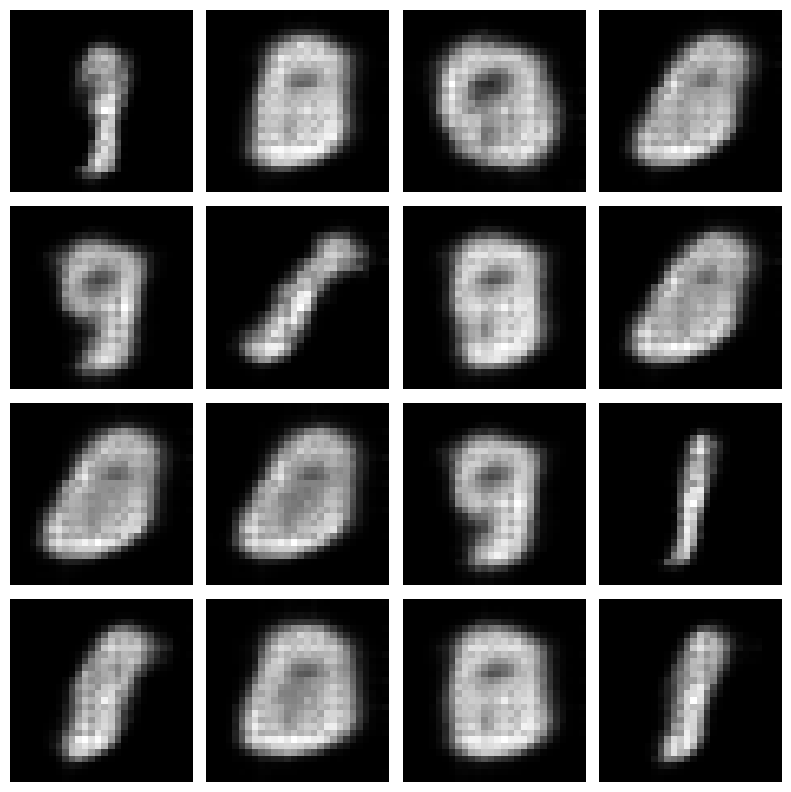

In [13]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

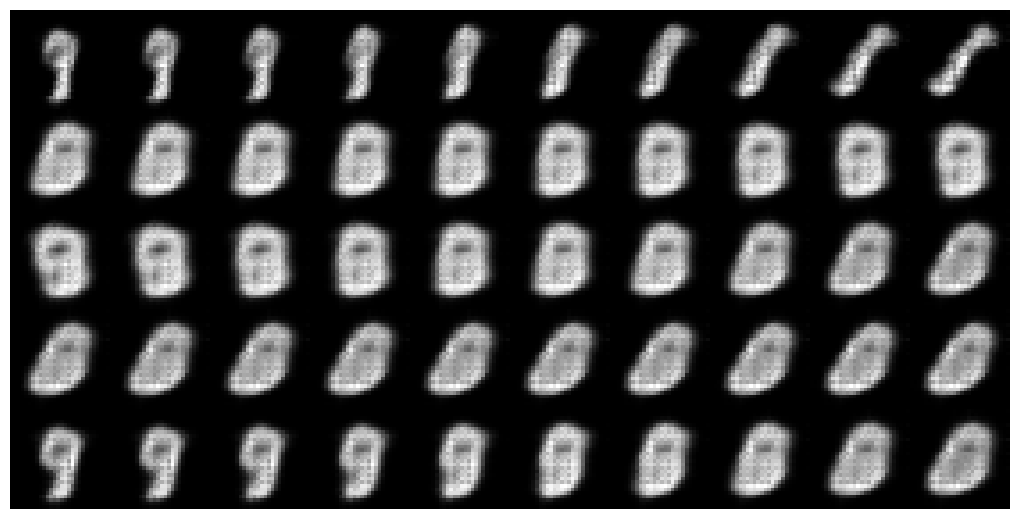

In [14]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [15]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, 28, 28)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


/home/dmandach/miniconda3/envs/py310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## Generators

### Normal Sampler

In [16]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

FID = 0.4664
IS [mean] = 1.6563
IS [std] = 0.2964


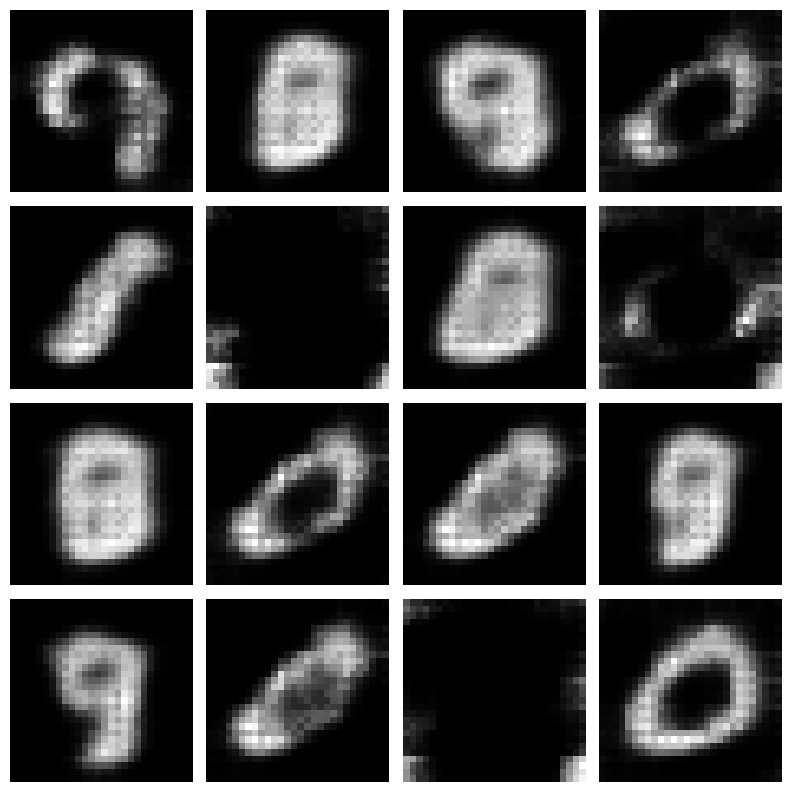

In [17]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

### Gaussian Mixture Model Sampler

In [18]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=3
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

FID = 0.3962
IS [mean] = 1.8851
IS [std] = 0.3921


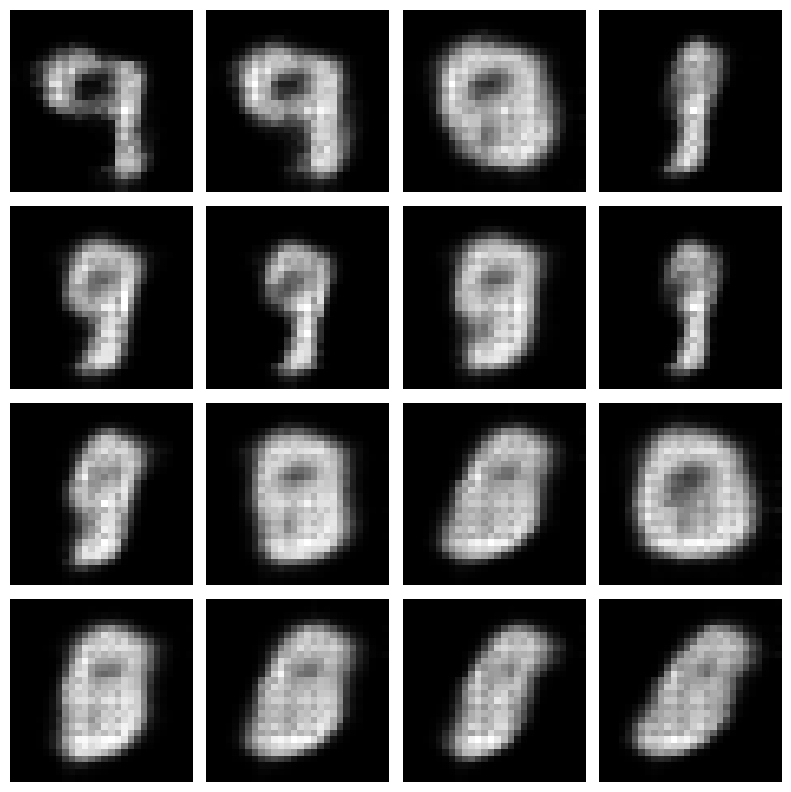

In [19]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

### RHVAE Sampler

In [20]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    # mcmc_steps_nbr = 200,
    # n_lf = 3,
    # eps_lf = 1e-3,
    # beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

FID = 0.4029
IS [mean] = 1.9986
IS [std] = 0.2539


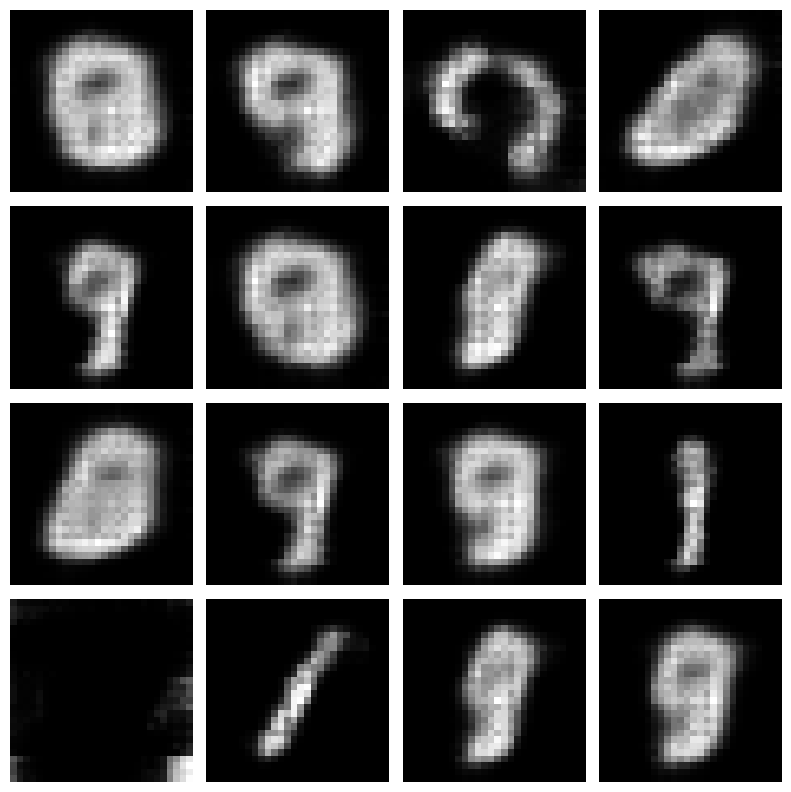

In [21]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)